### This script emulates the functionality of save_embedding from scib, but using a non scib-python environment. It allows multicore.

In [1]:
import scanpy as sc

import umap
umap.__version__


import pynndescent
pynndescent.__version__

from os.path import exists

from scipy import sparse

In [2]:
import numpy as np

In [3]:
def reduce_data(adata, batch_key=None, subset=False,
                filter=True, flavor='cell_ranger', n_top_genes=2000, n_bins=20,
                pca=True, pca_comps=50, overwrite_hvg=True,
                neighbors=True, use_rep='X_pca', 
                umap=True):
    """
    overwrite_hvg:
        if True, ignores any pre-existing 'highly_variable' column in adata.var
        and recomputes it if `n_top_genes` is specified else calls PCA on full features.
        if False, skips HVG computation even if `n_top_genes` is specified and uses
        pre-existing HVG column for PCA
    """
#     if n_top_genes is not None and overwrite_hvg:
#         print("HVG")
        
#         overwrite_hvg = False
        
#         ## quick fix: HVG doesn't work on dense matrix
#         if not sparse.issparse(adata.X):
#             adata.X = sparse.csr_matrix(adata.X)
            
#         if batch_key is not None:
#             hvg_list = hvg_batch(adata, batch_key=batch_key, target_genes=n_top_genes, n_bins=n_bins)
#             adata.var['highly_variable'] = np.in1d(adata.var_names, hvg_list)

#         else:
#             print(f"Calculating {n_top_genes} HVGs for reduce_data.")
#             sc.pp.highly_variable_genes(adata,
#                                         n_top_genes=n_top_genes,
#                                         n_bins=n_bins,
#                                         flavor=flavor)

#         n_hvg = np.sum(adata.var["highly_variable"])
#         print(f'Computed {n_hvg} highly variable genes')
    
    print('setting up HVGs')
    assert n_top_genes == adata.shape[1]
    adata.var["highly_variable"] = True
    n_hvg = np.sum(adata.var["highly_variable"])
        
    print('PCA and/or neighbors')
    if pca:
        print("PCA")
        use_hvgs = not overwrite_hvg and "highly_variable" in adata.var
        sc.tl.pca(adata,
                  n_comps=pca_comps, 
                  use_highly_variable=use_hvgs, 
                  svd_solver='arpack', 
                  return_info=True)
    
    if neighbors:
        n_jobs = 4
        print("Nearest Neigbours")
        sc.settings.n_jobs = n_jobs
        from joblib import parallel_backend
        import time
        start_time = time.time()
        with parallel_backend('threading', n_jobs=n_jobs): sc.pp.neighbors(adata, use_rep=use_rep)
        print("--- %s seconds ---" % (time.time() - start_time))
    
    if umap:
        print("UMAP")
        start_time = time.time()
        sc.tl.umap(adata)
        print("--- %s seconds ---" % (time.time() - start_time))
        
    # print('before return')
    # print(adata)


In [4]:
import scipy
import gc

In [5]:
# scipy.sparse.issparse(np.zeros(20))

In [29]:
print('hola')

hola


In [32]:
queries = [q for q in open('queries_postintegration_save_embeddings.sh')]
print(len(queries))
for q in queries:
    gc.collect()
    s = q.split(' ')
    input_pos = int([pi for pi, p in enumerate(s) if p == '-i' or p == '--input'][0])

    integrated_path = s[input_pos + 1] # .replace('retinal_all', 'retinal_500')

    embed_pos = int([pi for pi, p in enumerate(s) if p == '-i' or p == '--outfile'][0])
    embed_path =s[embed_pos + 1]

    print(exists(embed_path), embed_path)
    
    if exists(integrated_path) and not exists(embed_path):
        print('next query...')
        print(integrated_path)
        print(embed_path)
    else:
        continue

    result_pos = int([pi for pi, p in enumerate(s) if p == '-i' or p == '--result'][0])
    result =s[result_pos + 1].strip()
    
    print('result type', result)
    import os.path
    method = os.path.basename(integrated_path).split('.')[0]
    

    # if not 'retinal_all_Chen_' in embed_path:
    #     continue
    print(exists(embed_path), embed_path)

    if exists(embed_path):
        continue

    continue
    
    print('reading data...')    
    adata = sc.read_h5ad(integrated_path)
    print(adata.shape)
    
    print('Preparing dataset...')
    
    n_jobs = 10
    from joblib import parallel_backend
    import time
    start_time = time.time()
    
    
    if result == 'embed':
        reduce_data(adata, n_top_genes=None, neighbors=True,
                    use_rep='X_emb', pca=False, umap=False)
    elif result == 'full':
        sc.pp.filter_genes(adata, min_cells=1)
        reduce_data(adata, n_top_genes=adata.shape[1], neighbors=True,
                    use_rep='X_pca', pca=True, umap=False)

    print("--- Neighbors done: %s seconds ---" % (time.time() - start_time))        
    
    # print(adata)
    # Calculate embedding
    start_time = time.time()
    sc.settings.n_jobs = n_jobs
    if method.startswith('conos'):
        print('Calculating graph embedding...')
        sc.tl.draw_graph(adata, key_added_ext='graph')
        basis = 'draw_graph_graph'
        label = 'Graph'
    else:
        print('Calculating UMAP...')
        with parallel_backend('threading', n_jobs=n_jobs):
            sc.tl.umap(adata)
        basis = 'umap'
        label = 'UMAP'
        
        
    print("--- UMAP done: %s seconds ---" % (time.time() - start_time))
    
    print('done...')
    import os
    # Save embedding coordinates
    print('Saving embedding coordinates...')
    label = 'UMAP'
    basis = 'umap'
    adata.obs[label + '1'] = adata.obsm['X_' + basis][:, 0]
    adata.obs[label + '2'] = adata.obsm['X_' + basis][:, 1]
    coords = adata.obs[['cell.type', 'batch_donor_dataset', label + '1', label + '2' ]]
    coords.to_csv(os.path.join(embed_path), index_label='CellID')
    
    gc.collect()
    




24
True /storage/groups/ml01/workspace/ignacio.ibarra/theislab/retinal_scRNAseq_integration/data/integration_march_2021/output/retinal_all_all_batch_donor_dataset_cell.type/embeddings/unscaled/HVG.1K/scgen_full.csv
True /storage/groups/ml01/workspace/ignacio.ibarra/theislab/retinal_scRNAseq_integration/data/integration_march_2021/output/retinal_all_Chen_batch_donor_dataset_cell.type/embeddings/unscaled/HVG.1K/scvi_embed.csv
True /storage/groups/ml01/workspace/ignacio.ibarra/theislab/retinal_scRNAseq_integration/data/integration_march_2021/output/retinal_all_Chen+Roska_batch_donor_dataset_cell.type/embeddings/unscaled/HVG.1K/scvi_embed.csv
True /storage/groups/ml01/workspace/ignacio.ibarra/theislab/retinal_scRNAseq_integration/data/integration_march_2021/output/retinal_all_Chen+Hackney_batch_donor_dataset_cell.type/embeddings/unscaled/HVG.1K/scvi_embed.csv
True /storage/groups/ml01/workspace/ignacio.ibarra/theislab/retinal_scRNAseq_integration/data/integration_march_2021/output/retinal_

In [25]:
# print(adata)
# Calculate embedding
start_time = time.time()
sc.settings.n_jobs = n_jobs
if method.startswith('conos'):
    print('Calculating graph embedding...')
    sc.tl.draw_graph(adata, key_added_ext='graph')
    basis = 'draw_graph_graph'
    label = 'Graph'
else:
    print('Calculating UMAP...')
    with parallel_backend('threading', n_jobs=n_jobs):
        sc.tl.umap(adata)
    basis = 'umap'
    label = 'UMAP'


print("--- UMAP done: %s seconds ---" % (time.time() - start_time))

print('done...')
import os
# Save embedding coordinates
print('Saving embedding coordinates...')
label = 'UMAP'
basis = 'umap'
adata.obs[label + '1'] = adata.obsm['X_' + basis][:, 0]
adata.obs[label + '2'] = adata.obsm['X_' + basis][:, 1]
coords = adata.obs[['cell.type', 'batch_donor_dataset', label + '1', label + '2' ]]
coords.to_csv(os.path.join(embed_path), index_label='CellID')

gc.collect()


Calculating UMAP...
--- UMAP done: 6953.135392189026 seconds ---
done...
Saving embedding coordinates...


28799

In [26]:
print('here...')

here...


# The section here is solely for debugging purposes

In [23]:
adata.shape

(1785526, 1000)

In [7]:
# integrated_path = integrated_path.replace('retinal_all_', 'retinal_500_')
integrated_path

'/storage/groups/ml01/workspace/ignacio.ibarra/theislab/retinal_scRNAseq_integration/data/integration_march_2021/output/retinal_all_all_batch_donor_dataset_cell.type/integration/unscaled/HVG.1K/scgen.h5ad'

In [8]:
adata = sc.read_h5ad(integrated_path)
print(adata.shape)

(2159366, 1000)


In [9]:
adata.shape

(2159366, 1000)

In [10]:
n_jobs = 10

from joblib import parallel_backend
import time
start_time = time.time()

print('Preparing dataset...')
if result == 'embed':
    reduce_data(adata, n_top_genes=None, neighbors=True,
                use_rep='X_emb', pca=False, umap=False)
elif result == 'full':
    print('filtering genes...')
    sc.pp.filter_genes(adata, min_cells=1)
    print('reducing data...')
    reduce_data(adata, n_top_genes=adata.shape[1], neighbors=True,
                use_rep='X_pca', pca=True, umap=False)

    
print("--- Neighbors done: %s seconds ---" % (time.time() - start_time))


Preparing dataset...
filtering genes...


/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


reducing data...
setting up HVGs
PCA and/or neighbors
PCA
Nearest Neigbours
--- 928.7356851100922 seconds ---
--- Neighbors done: 1691.5949726104736 seconds ---


In [11]:
print('here...')

here...


In [12]:

start_time = time.time()
sc.settings.n_jobs = n_jobs
with parallel_backend('threading', n_jobs=n_jobs):
    sc.tl.umap(adata)
print("--- UMAP done: %s seconds ---" % (time.time() - start_time))


--- UMAP done: 3325.8637838363647 seconds ---


In [13]:
print('here...')

here...


In [17]:
sc.set_figure_params(facecolor='white', dpi=120)

In [20]:
# adata.obs.columns

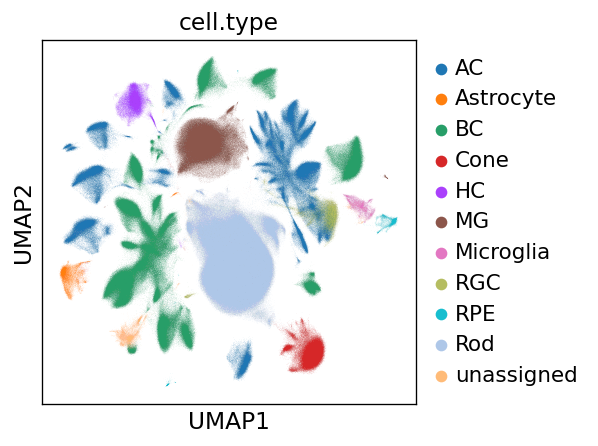

In [19]:
sc.pl.umap(adata, color='cell.type')